In [ ]:
#default_exp bbox

In [ ]:
#export
from fastcore.test import *
import xml.etree.ElementTree as ET
import cv2
from collections import defaultdict

In [ ]:
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
%config Completer.use_jedi = False

In [ ]:
img_path = Path('/mnt/data/smarttray/dataset_05jul2021_av3b/run_3_revisited_5may2021/val/images/1610714264070_11.jpg')
xml_path = img_path.parent.parent/'annotations'/(img_path.stem+'.xml')
img_path.exists(), xml_path.exists()

(True, True)

In [ ]:
#export
def bb_in_relative_coords(bb): return all(map(lambda x: 0 <= x <= 1, bb))

In [ ]:
bb1, bb2 = [.2, .1, .4, .6], [0, 1, 40, 50]

test_eq(bb_in_relative_coords(bb1), True)
test_eq(bb_in_relative_coords(bb2), False)

In [ ]:
#export
class BBFormats():
    def __init__(self):
        self.two_points = 'two_points'
        self.array_coords = 'array_coords'
        self.coco = 'coco'

class BBox():
    def __init__(self, bb, bb_format='two_points'):
#         if len(args) >= 1 : bb = [bb] + list(args)
                
        if bb_format=='two_points': 
            x1, y1, x2, y2 = bb
        
        if bb_format=='array_coords':             
            y1, x1, y2, x2 = bb
            
        if bb_format=='coco':
            x1, y1, w, h = bb
            x2, y2 = x1 + w, y1 + h
        
        self.coords = [x1, y1, x2, y2]
    
    def __getitem__(self, i): return self.coords[i] 
    def __iter__(self): return iter(self.coords)
    
    @property
    def x1(self): return self.coords[0]

    @property
    def y1(self): return self.coords[1]

    @property
    def x2(self): return self.coords[2]

    @property
    def y2(self): return self.coords[3]

    @property
    def w(self): return self.x2 - self.x1
        
    @property
    def h(self): return self.y2 - self.y1
    
    @property
    def in_relative_coords(self): return bb_in_relative_coords(self.coords)
        
    @property
    def coco_coords(self): return [self.x1, self.y1, self.w, self.h]
    
    @property
    def array_coords(self): return [self.y1, self.x1, self.y2, self.x2]
    
    def as_slice(self): 
        if not self.in_relative_coords: 
            return (slice(self.y1, self.y2), slice(self.x1, self.x2))
        else:
            raise Exception("Your bb should be in absolute coords i.e. not between 0 and 1")
    
    def to_relative(self, im_w, im_h):
        if not self.in_relative_coords:
            x1, y1, x2, y2 = self.coords
            self.coords = [x1/im_w, y1/im_h, x2/im_w, y2/im_h]
            return self

    def to_absolute(self, im_w, im_h):
        if self.in_relative_coords:
            x1, y1, x2, y2 = self.coords
            self.coords = [int(x1*im_w), int(y1*im_h), int(x2*im_w), int(y2*im_h)]
            return self
        
    def shift(self, X, Y):
        self.coords = [self.x1 + X, self.y1 + Y, self.x2 + X, self.y2 + Y]
        return self
        
    def __repr__(self): return str(self.coords)

In [ ]:
bb = [6, 2, 40, 50]
bb = BBox(bb, bb_format='coco')

test_eq(bb.coords, [6, 2, 46, 52])

bb.to_absolute(100,200)
test_eq(bb.coords, [6, 2, 46, 52])

bb.to_relative(100,200)
test_eq(bb.coords, [6/100, 2/200, 46/100, 52/200])

bb.to_relative(100,200)
test_eq(bb.coords, [6/100, 2/200, 46/100, 52/200])

bb.to_absolute(50,100)
test_eq(bb.coords, [3, 1, 23, 26])

In [ ]:
#export
def read_xml_anns(xml_file: str, properties=[]):                                                                                                                                                                                                                                      
    tree = ET.parse(xml_file)                                                                                                                                                                                                                                                   
    root = tree.getroot()                                                                                                                                                                                                                                                       
    anns = defaultdict(list)                                                                                                                                                                                                                                                   
    for boxes in root.iter('object'):
        
        for prop_name in properties: anns[prop_name].append(boxes.find(prop_name).text)
        anns["name"].append(boxes.find("name").text)

        ymin, xmin, ymax, xmax = None, None, None, None                                                                                                                                                                                                                         
        ymin = int(float(boxes.find("bndbox/ymin").text))                                                                                                                                                                                                                       
        xmin = int(float(boxes.find("bndbox/xmin").text))                                                                                                                                                                                                                       
        ymax = int(float(boxes.find("bndbox/ymax").text))                                                                                                                                                                                                                       
        xmax = int(float(boxes.find("bndbox/xmax").text))        
        anns["bbs"].append(BBox([xmin, ymin, xmax, ymax]))
        
    return anns

In [ ]:
bbs = read_xml_anns(xml_path)["bbs"]
bbs

[[629, 486, 1379, 1262], [728, 1571, 1149, 2043], [1407, 1446, 2156, 1933]]

In [ ]:
#export
def draw_bbs(img, bbs, color=[0,0,255]):
    h, w, _ = img.shape
    for bb in bbs:
        bb.to_absolute(w,h)
        x1, y1, x2, y2 = bb
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 10)

def area(bb:BBox): return bb.w*bb.h

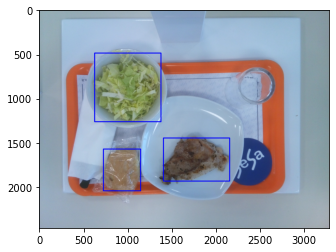

In [ ]:
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_bbs(img, bbs)
plt.imshow(img)

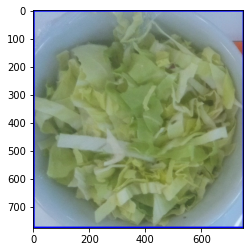

In [ ]:
bb = bbs[0]
w,h,_ = img.shape
bb.to_absolute(w,h)
plt.imshow(img[bb.as_slice()])